Fetch hourly historic price data from the Cryptocompare API and build a machine learning model for your cryptocurrency of choice that predicts if the price is going to go up or down in the next hour.

Next, build a model that predicts if the price will go up or down for the next 6 hours (one prediction per hour).

In [50]:
import requests
import json
import calendar
import random 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, MaxPooling1D, LeakyReLU, PReLU
from keras.utils import np_utils
from keras.callbacks import CSVLogger, ModelCheckpoint
import h5py
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from statsmodels.tsa.api import ExponentialSmoothing, Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_error
import math 

%matplotlib inline 

url = 'https://min-api.cryptocompare.com/data/histohour?tsym=EUR&limit=5000&fsym=BTC'
response = requests.get(url)

json_array = json.loads(response.text)
df = pd.DataFrame(json_array['Data'], columns = ['close','time'])

# Naive forecat based on moving average

RMSE: 142.7225673679937


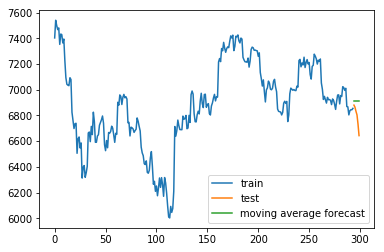

In [51]:
#df['time'] = pd.to_datetime(df['time'], unit='s')
#df.set_index('time', inplace=True)

train, test = df[:294], df[294:300]
y = test.copy()
y['mav'] = train['close'].rolling(12).mean().iloc[-1]

plt.plot(train['close'], label='train')
plt.plot(test['close'], label='test')
plt.plot(y['mav'], label='moving average forecast')
plt.legend(loc='best')

print("RMSE: {}".format(math.sqrt(mean_squared_error(test['close'],y['mav']))))


# holt linear forecast

RMSE: 74.1946104595459


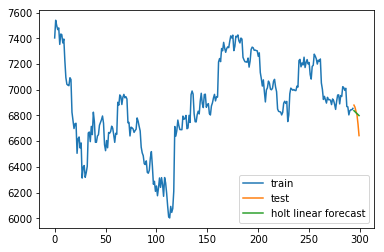

In [52]:
y = test.copy()
fit1 = Holt(np.asarray(train['close'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y['holt_linear'] = fit1.forecast(len(test))

plt.plot(train['close'], label='train')
plt.plot(test['close'], label='test')
plt.plot(y['holt_linear'], label='holt linear forecast')
plt.legend(loc='best')

print("RMSE: {}".format(math.sqrt(mean_squared_error(test['close'],y['holt_linear']))))

# Holt Winter forecast

Dickey–Fuller test: p=0.142338


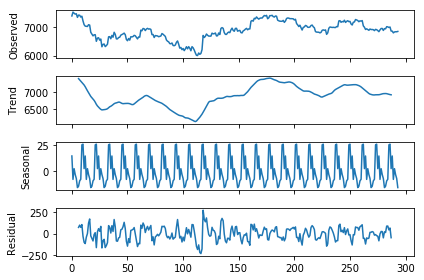

In [56]:
seasonal_decompose(train['close'], model='additive',freq=12).plot()
print("Dickey–Fuller test: p=%f" % adfuller(train['close'])[1])


Dickey–Fuller test is quite low, indicates low probablility of sesonality in the data. It's not good but we sitll process with sesonal models. Based on the domain research it looks like this kind of data should expose sesonality.  

RMSE: 104.4911945355767


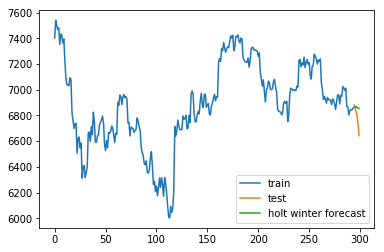

In [57]:
y = test.copy()

#do some grid search to optymize params
fit1 = ExponentialSmoothing(np.asarray(train['close']) ,seasonal_periods=7 ,trend='additive', seasonal='mul',).fit()
y['Holt_Winter'] = fit1.forecast(len(test))

plt.plot(train['close'], label='train')
plt.plot(test['close'], label='test')
plt.plot(y['Holt_Winter'], label='holt winter forecast')
plt.legend(loc='best')

print("RMSE: {}".format(math.sqrt(mean_squared_error(test['close'],y['Holt_Winter']))))

RMSE: 94.43835886902701


C:\Users\martinX1\Anaconda3\lib\site-packages\statsmodels-0.10.0-py3.6-win-amd64.egg\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


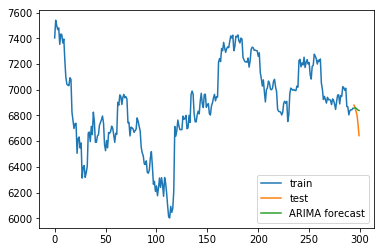

In [58]:
y = test.copy()

#do some grid search to optymize params
fit1 = SARIMAX(train.close, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit(maxiter=500, method='nm')
y['SARIMA'] = fit1.forecast(len(test))

plt.plot(train['close'], label='train')
plt.plot(test['close'], label='test')
plt.plot(y['SARIMA'], label='ARIMA forecast')
plt.legend(loc='best')

print("RMSE: {}".format(math.sqrt(mean_squared_error(test['close'],y['SARIMA']))))

Next models to check:
- Convolutional Neural Network as it should capture the data locality
- Long Short Term Memory is generally well suited for time series data
- use stacking/stacknet to combine different models

Play more with data:
- feature enginiering, designing some complex features based on the data we have
- probaly volume also can be used in the model 
- add sentiment analysis

- How well does your model perform? How does it compare to the simplest baseline model you can think of?

-- I use RMSE to compare models. I will use Holt's Winters as Arime has issues with converging, first fix the use before using the model. There should be more sohisticated model selection, some CV, parameters optymization. 

- How does the 1-hour-prediction-model compare to the 6-hour-prediction-model?

-- I used the same models for all predictions, but with more time I'd be beneficial investigating if simpler models do not perform better for 1-h. The first element in the results is 1-h prediction. 

- Where do you see the main challenge in building a model like the one we asked here?

-- It's a similar prblem to predicting stock price and it has been well researched. Captiring the dynamics and shapr changes in price and volume are not trivial. It is also well known that highly precise prediction are essentially impossible/ Moreover, any model will have to evolve dinaically as the more people will be isng it the more inaccurate it will become. 

- What would you do if you had more time to improve the model?

-- tune the existing models and do proper model selection

-- better use of the data (include volume, time of a day, day od a week, week of a month, etc.)

-- try more complex models

-- add sentiment analysis 

-- read up on stock pricex and forex predictions

-- With such simple models addding (2000 records) more dara increase the error. to be investigated. 

- What additional data would you incorporate if you had access to it? Why?

-- answered above

The models are far from perfect, they do not capture sharp changes, probably some way of pre-clustering data and using more historical data of the prices can help select several patterns, and finally building an ensomble learnign based on this models. 